In [1]:
from __future__ import print_function

__docformat__ = 'restructedtext en'

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import _pickle as cPickle
import gzip
import os
import sys
import timeit
from sklearn.metrics import confusion_matrix
import math
import os

In [3]:
# Import Theano
# Calculate the time it takes to import Theano
start_time = timeit.default_timer()
import theano
end_time = timeit.default_timer()
print("It took Theano %.1fs to load." % (end_time - start_time))

It took Theano 3.9s to load.


Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 860M (0000:01:00.0)


In [4]:
import theano.tensor as T
from theano.printing import pydotprint

In [5]:
# Initialize Random Seed for Randomness

# Set seed for the random numbers
rng = np.random.seed(1234)
rng = np.random.RandomState(1234)

In [6]:
# import LogisticRegression and load_mnist_data functions from mnist_logistic_regression.py
from mnist_logistic_regression_model import LogisticRegression

from load_mnist_dataset import load_mnist_data
dataset = '/home/dashsid/MNIST/mnist.pkl.gz'

# load the dataset
datasets = load_mnist_data(dataset)
    
# retrieve the correct dataset partitions
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

/home/dashsid/MNIST
mnist.pkl.gz
Loading MNIST data...


In [7]:
# Print the no of training, validation, and test data

# Print the type of the shared variable for the dataset
print(train_set_x)

print(train_set_x.get_value())
print(valid_set_x.get_value())
print(test_set_x.get_value())

print("Size of the training dataset: ", train_set_x.get_value().shape)
print("Size of the validation dataset: ", valid_set_x.get_value().shape)
print("Size of the test dataset: ", test_set_x.get_value().shape)

<GpuArrayType<None>(float32, (False, False))>
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Size of the training dataset:  (50000, 784)
Size of the validation dataset:  (10000, 784)
Size of the test dataset:  (10000, 784)


## Define Network and Data Parameters

In [8]:
# Data dimensions

# MNIST images are 28 pixels in each dimension
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size
n_input = img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10
n_output = num_classes

In [9]:
# Training Parameters
learning_rate = 0.01
batch_size = 32
n_hidden = [1024, 1024]
activation = T.nnet.relu
# activation = T.nnet.sigmoid

## Visualize the Data from the Actual Dataset

In [10]:
from utils import tile_raster_images

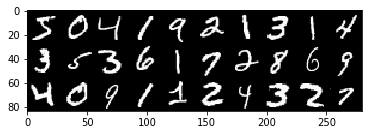

In [11]:
samples = tile_raster_images(train_set_x.get_value(), img_shape=img_shape, 
                             tile_shape=(3, 10), tile_spacing=(0, 0), scale_rows_to_unit_interval=True, 
                             output_pixel_vals=True)
plt.imshow(samples, cmap='gray')
plt.show()

In [12]:
# Print the labels from the dataset
print(train_set_y)

print(train_set_y[:10].eval())

Elemwise{Cast{int32}}.0
[5 0 4 1 9 2 1 3 1 4]


## Data Normalization - PreProcessing

In [13]:
# Apply mean and standard deviation to normalize the data
norm_mean = train_set_x.mean(axis=0)
norm_std =  train_set_x.std(axis=0)
norm_std = norm_std.clip(0.00001, norm_std.max())

# Normalize the training data
train_set_x = train_set_x - norm_mean
train_set_x = train_set_x / norm_std

# Normalize the test data
test_set_x = test_set_x - norm_mean
test_set_x = test_set_x / norm_std

# Normalize the validation data
valid_set_x = valid_set_x - norm_mean
valid_set_x = valid_set_x / norm_std

### Visualize the Pre-Processed Data

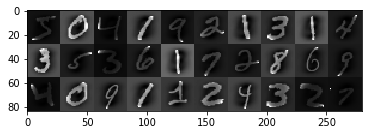

In [14]:
samples = tile_raster_images(train_set_x.eval(), img_shape=(img_size, img_size), 
                             tile_shape=(3, 10), tile_spacing=(0, 0), scale_rows_to_unit_interval=True, 
                             output_pixel_vals=True)
plt.imshow(samples, cmap='gray')
plt.show()

In [15]:
print("Before creating shared variables...")
print(train_set_x)

train_set_x = theano.shared(train_set_x.eval())
valid_set_x = theano.shared(valid_set_x.eval())
test_set_x = theano.shared(test_set_x.eval())

print("After creating shared variables...")
print(train_set_x)
print(valid_set_x)
print(test_set_x)

Before creating shared variables...
Elemwise{true_div,no_inplace}.0
After creating shared variables...
<GpuArrayType<None>(float32, (False, False))>
<GpuArrayType<None>(float32, (False, False))>
<GpuArrayType<None>(float32, (False, False))>


## Create a Feed Forward Network with Hidden Layers

## Define a Class to Construct Hidden Layers

In [16]:
class HiddenLayer(object):
    
    # Initialize the parameters
    def __init__(self, rng, input, n_in, n_out, W=None, b=None, activation=activation):
        
        # Model input
        self.input = input
        
        # Model Weights - uniformly sampled from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function.
        # The output is converted to dtype theano.config.floatX to run the code on GPU.
        if W is None:
            W_bound = np.sqrt(1. / (n_in + n_out))
            W_values = np.asarray(rng.uniform(low=-W_bound, high=W_bound, size=(n_in, n_out)),
                                 dtype=theano.config.floatX)
            
            # W_values = np.asarray(rng.normal(size=(n_in, n_out)), dtype=theano.config.floatX)
            # If using sigmoid activation fuction, multiply the value of weights by 4 times larger than tanh.
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4
            
            W = theano.shared(value=W_values, name='W', borrow=True)
        
        # Model biases
        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)
        
        # Initialize the weights and variables
        self.W = W
        self.b = b
        
        # If the activation function is not tanh, use linear activation function
        lin_output = T.dot(input, self.W) + self.b
        self.output = (lin_output if activation is None 
                       else activation(lin_output))
        
        # model parameters
        self.params = [self.W, self.b]

## Define a Class to Construct a Feed-Forward Network with Hidden Layers

In [17]:
class MLP(object):
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        
        self.hiddenLayers = []
        
        self.params = []
        
        next_input = input
        next_n_in = n_in
        
        # Define a Hidden Layer
        for n_h in n_hidden:
            hl = HiddenLayer(rng=rng, input=next_input, n_in=next_n_in, n_out=n_h, activation=activation)
            next_input = hl.output
            next_n_in = n_h
            self.hiddenLayers.append(hl)
            self.params += hl.params
        
        # Define the Final Layer - here, input is the output of the hidden layer
        self.logRegressionLayer = LogisticRegression(input=self.hiddenLayers[-1].output, n_in=n_hidden[-1], 
                                                     n_out=n_out)
        
        # Apply L1 and L2 regularization - enforce L1 and L2 norms to be small
        # L1 = T.sum(abs(param))
        # self.L1 = (abs(self.hiddenLayer.W).sum() + abs(self.logRegressionLayer.W).sum())
        
        # L2 = T.sum(param ** 2)
        # self.L2_sqr = ((self.hiddenLayer.W ** 2).sum() + (self.logRegressionLayer.W ** 2).sum())
        
        # negative log likelihood of the MLP is given by the negative log likelihood of the output of the model,
        # computed in the logistic regression layer
        self.negative_log_likelihood = (self.logRegressionLayer.negative_log_likelihood)
        
        # Compute the number of errors in the logistic regression layer
        self.errors = self.logRegressionLayer.errors
        
        # Compute the accuracy of the model
        self.accuracy = self.logRegressionLayer.accuracy
        
        # parameters of the model are the parameters of the two layer it is made out of
        self.params += self.logRegressionLayer.params

## Declare Placeholders for Theano Shared Variables

In [18]:
# Create symbolic variables for input data, x represents rasterized images, y represents labels
x = T.fmatrix('x')
y = T.ivector('y')

In [19]:
# create a symbolic variable for the index to a minibatch
index = T.lscalar('batch_index')

In [20]:
# compute no of minibatches for training, validation and testing
# // operator is used for integer floor division
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

# n_train_batches = train_set_x.shape[0].eval() // batch_size
print("# of Training batches", n_train_batches)
print("# of Validation batches", n_valid_batches)
print("# of Test batches", n_test_batches)

# of Training batches 1562
# of Validation batches 312
# of Test batches 312


## Theano Functions with Shared Variable Input

In [21]:
trainx = train_set_x.eval()
trainy = train_set_y.eval()

validx = valid_set_x.eval()
validy = valid_set_y.eval()

testx = test_set_x.eval()
testy = test_set_y.eval()

## Build the MLP Model Classifier

In [22]:
# construct the MLP model
classifier = MLP(rng=rng, input=x, n_in=n_input, n_hidden=n_hidden, n_out=n_output)
    
# find the cost without L1/L2 regularization
cost = classifier.negative_log_likelihood(y)
    
# find the cost with L1/L2 regularization
# cost = (classifier.negative_log_likelihood(y) + L1_reg * classifier.L1 + L2_reg * classifier.L2_sqr)
    
# compute the gradient of cost w.r.t theta (sorted in params)
# the resulting gradients will be stored in a list gparams
gparams = [T.grad(cost, param) for param in classifier.params]
    
# Compute the gradient descent step to update the parameters at each learning step for optimization
updates = [(param, param - learning_rate * gparam) for param, gparam in zip(classifier.params, gparams)]

# compute the errors
errors = classifier.errors(y)

# compute the accuracy
accuracy = classifier.accuracy(y)
    
# compile the Theano function for the test model
test_model = theano.function(inputs=[index], 
                             outputs=errors, 
                             givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                     y: test_set_y[index * batch_size: (index + 1) * batch_size]})
    
    
# Theano function for test model accuracy
test_model_accuracy = theano.function(inputs=[index], 
                                      outputs=accuracy, 
                                      givens={x: test_set_x[index * batch_size: (index + 1) * batch_size], 
                                              y: test_set_y[index * batch_size: (index + 1) * batch_size]})
    
    
# compile the Theano function for the validation model
validate_model = theano.function(inputs=[index], 
                                 outputs=errors, 
                                 givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size], 
                                         y: valid_set_y[index * batch_size: (index + 1) * batch_size]})
    

# Theano function for validation model accuracy
valid_model_accuracy = theano.function(inputs=[index], 
                                       outputs=accuracy, 
                                       givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size], 
                                               y: valid_set_y[index * batch_size: (index + 1) * batch_size]})
    

# compile the Theano function for the train model
train_model = theano.function(inputs=[index], 
                              outputs=cost, 
                              updates=updates, 
                              givens={x: train_set_x[index * batch_size: (index + 1) * batch_size], 
                                      y: train_set_y[index * batch_size: (index + 1) * batch_size]})


# Theano function for the train model accuracy
train_model_accuracy = theano.function(inputs=[index], 
                                       outputs=accuracy, 
                                       updates=updates, 
                                       givens={x: train_set_x[index * batch_size: (index + 1) * batch_size], 
                                               y: train_set_y[index * batch_size: (index + 1) * batch_size]})

## Perform Classifier Training

## Helper Function to Perform Optimization

In [23]:
def test_mlp(learning_rate, n_epochs, dataset, batch_size, n_hidden):
    
    # ---------------
    # Train the model
    # ---------------
    print("Training the MLP model...")
    
    
    # keep track of the validation loss and the test scores
    start_time = timeit.default_timer()
    
    # ----------------------------------------------------------
    # Begin the training loop
    # The outer while loop loops over the no of iterations (epochs)
    # The inner loop loops over the minibatches
    finished = False
    curr_epoch = 0
    
    while (curr_epoch < n_epochs) and (not finished):
        
        curr_epoch += 1
        
        for minibatch_i in range(n_train_batches):
            
            # calculate the average likelihood(cost) for the minibatches
            minibatch_avg_cost = train_model(minibatch_i)
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            # perform iterations on validation set
            if ((iter + 1) % n_train_batches == 0):
                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)
                
                # evaluate the train loss on the training batches
                # train_loss = [train_model(i) for i in range(n_train_batches)]
                train_loss= [train_model(i) for i in range(n_train_batches)]

                train_accuracy = [train_model_accuracy(i) for i in range(n_train_batches)]

                # find the average train loss for each training batch
                train_avg_loss = np.mean(train_loss)

                train_avg_accuracy = np.mean(train_accuracy)
                
                
                # evaluate the validation loss on the validation batches
                # validation_loss = [validate_model(i) for i in range(n_valid_batches)]
                valid_loss = [validate_model(i) for i in range(n_valid_batches)]

                valid_accuracy = [valid_model_accuracy(i) for i in range(n_valid_batches)]

                # find the average validation loss for each batch
                valid_avg_loss = np.mean(valid_loss)

                valid_avg_accuracy = np.mean(valid_accuracy)
                
                
                # evaluate the test loss on the test batches
                # test_loss = [test_model(i) for i in range(n_test_batches)]
                test_loss = [test_model(i) for i in range(n_test_batches)]

                test_accuracy = [test_model_accuracy(i) for i in range(n_test_batches)]

                # find the average test loss for each batch
                test_avg_loss = np.mean(test_loss)

                test_avg_accuracy = np.mean(test_accuracy)
                
                
                msg = "Training Accuracy: {0:>6.1%}, Validation Accuracy: {1:>6.1%}"
                print(msg.format(train_avg_accuracy, valid_avg_accuracy))

                msg1 = ("Training Cost %f %%, Validation Loss %f %%") % (train_avg_loss * 100., valid_avg_loss * 100.)
                print(msg1)
                    
                # serialize the model to disk using pickle
                with open('best_mnist_mlp_model.pkl', 'wb') as f:
                    cPickle.dump(classifier, f)
                    
                print("=====================================================================")
                print("=====================================================================")
                
    end_time = timeit.default_timer()
    
    time_diff = end_time - start_time
    
    train_perf_score = train_avg_loss * 100.
    valid_perf_score = valid_avg_loss * 100.
    test_perf_score = test_avg_loss * 100.
    
    train_best_accuracy = train_avg_accuracy * 100.
    valid_best_accuracy = valid_avg_accuracy * 100.
    test_best_accuracy = test_avg_accuracy * 100.
    
    print(("Optimization completed with training performance score of %f %%, validation peformance score of %f %%, \
           and test performance score of %f %%") % (train_perf_score, valid_perf_score, test_perf_score))
    
    print(("Training Accuracy %f %%, Validation Accuracy %f %%, and Test Accuracy %f %%") % 
          (train_best_accuracy, valid_best_accuracy, test_best_accuracy))
    
    print("The code ran for %d epochs, with %f epochs/sec" % (curr_epoch, 1. * curr_epoch / time_diff))
    print("The code ran for %.1fs" % time_diff)
    
    print("The code ran for %.2fm" % (time_diff / 60.))

In [24]:
test_mlp(learning_rate=learning_rate, n_epochs=100, dataset=dataset, batch_size=batch_size, n_hidden=n_hidden)

Training the MLP model...
Epoch 1, Minibatch 1562/1562 
Training Accuracy:  94.3%, Validation Accuracy:  95.2%
Training Cost 27.316231 %, Validation Loss 4.757612 %
Epoch 2, Minibatch 1562/1562 
Training Accuracy:  97.0%, Validation Accuracy:  96.6%
Training Cost 12.699340 %, Validation Loss 3.375401 %
Epoch 3, Minibatch 1562/1562 
Training Accuracy:  98.1%, Validation Accuracy:  97.2%
Training Cost 7.828490 %, Validation Loss 2.834535 %
Epoch 4, Minibatch 1562/1562 
Training Accuracy:  98.9%, Validation Accuracy:  97.4%
Training Cost 5.178530 %, Validation Loss 2.614183 %
Epoch 5, Minibatch 1562/1562 
Training Accuracy:  99.3%, Validation Accuracy:  97.5%
Training Cost 3.425437 %, Validation Loss 2.544071 %
Epoch 6, Minibatch 1562/1562 
Training Accuracy:  99.6%, Validation Accuracy:  97.4%
Training Cost 2.363275 %, Validation Loss 2.554087 %
Epoch 7, Minibatch 1562/1562 
Training Accuracy:  99.8%, Validation Accuracy:  97.5%
Training Cost 1.663301 %, Validation Loss 2.504006 %
Epoch 

Epoch 31, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.7%
Training Cost 0.068413 %, Validation Loss 2.253606 %
Epoch 32, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.064958 %, Validation Loss 2.233574 %
Epoch 33, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.061796 %, Validation Loss 2.233574 %
Epoch 34, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.058898 %, Validation Loss 2.243590 %
Epoch 35, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.056239 %, Validation Loss 2.233574 %
Epoch 36, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.053782 %, Validation Loss 2.233574 %
Epoch 37, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.051512 %, Validation Loss 2.233574 %
Epoch 38, Minibatch 1562/15

Epoch 61, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.024425 %, Validation Loss 2.193510 %
Epoch 62, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.023866 %, Validation Loss 2.193510 %
Epoch 63, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.023329 %, Validation Loss 2.193510 %
Epoch 64, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.022814 %, Validation Loss 2.193510 %
Epoch 65, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.022319 %, Validation Loss 2.193510 %
Epoch 66, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.021843 %, Validation Loss 2.193510 %
Epoch 67, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.021384 %, Validation Loss 2.193510 %
Epoch 68, Minibatch 1562/15

Epoch 91, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.014013 %, Validation Loss 2.183494 %
Epoch 92, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.013807 %, Validation Loss 2.183494 %
Epoch 93, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.013607 %, Validation Loss 2.183494 %
Epoch 94, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.013411 %, Validation Loss 2.183494 %
Epoch 95, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.013221 %, Validation Loss 2.183494 %
Epoch 96, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.013036 %, Validation Loss 2.183494 %
Epoch 97, Minibatch 1562/1562 
Training Accuracy: 100.0%, Validation Accuracy:  97.8%
Training Cost 0.012855 %, Validation Loss 2.183494 %
Epoch 98, Minibatch 1562/15

## Helper Function to Plot Weights

In [25]:
def plot_weights(weights, cmap):
    
    # print statistics for the weights
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(weights.min(), weights.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(weights.mean(), weights.std()))
    
    filters = tile_raster_images(weights, img_shape=img_shape, tile_shape=(6, 10), tile_spacing=(1, 1), 
                                 scale_rows_to_unit_interval=True, output_pixel_vals=True)
        
    # plot the weights
    plt.imshow(filters, cmap=cmap)
    plt.show()

## Plot the Hidden Layer Weights

Min:  -0.12600, Max:   0.13368
Mean: -0.00046, Stdev: 0.01638


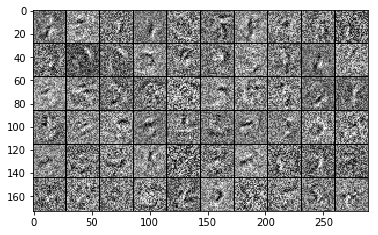

In [26]:
hidden_weights = classifier.hiddenLayers[0].W.T.eval()

plot_weights(hidden_weights, cmap='gray')